In [36]:
from exact_coeffs import interpolation_coeffs
import numpy as np
import aesara.tensor as at

In [166]:
def chiq_exact_factors(chi, Q, bij, cij, Y0):
    chi_Q = np.array([[(chi**j) * (Q**i) for i in range(4)] for j in range(4)])
    return np.array([Y0[mode] * np.sum(bij[mode]*chi_Q) / np.sum(cij[mode]*chi_Q) for mode in range(len(bij))])

def chiq_exact_factors_new(chi, Q, Y0_bij, cij):
    chi_Q = at.stack([[(chi**0) * (Q**0),(chi**0) * (Q**1),(chi**0) * (Q**2),(chi**0) * (Q**3)],
                                     [(chi**1) * (Q**0),(chi**1) * (Q**1),(chi**1) * (Q**2),(chi**1) * (Q**3)],
                                     [(chi**2) * (Q**0),(chi**2) * (Q**1),(chi**2) * (Q**2),(chi**2) * (Q**3)],
                                     [(chi**3) * (Q**0),(chi**3) * (Q**1),(chi**3) * (Q**2),(chi**3) * (Q**3)]])
    
    return at.tensordot(Y0_bij, chi_Q,axes=[[1,2],[0,1]])/(at.tensordot(cij, chi_Q,axes=[[1,2],[0,1]]))


def chi_factors(chi, coeffs):
    log1mc = at.log1p(-chi)
    log1mc2 = log1mc*log1mc
    log1mc3 = log1mc2*log1mc
    log1mc4 = log1mc2*log1mc2
    v = at.stack([chi, at.as_tensor_variable(1.0), log1mc, log1mc2,
                  log1mc3, log1mc4])

    return at.dot(coeffs, v)

In [200]:
def factors(b_omega, c_omega, b_gamma, c_gamma, Y0_omega, Y0_gamma):
    Y0_bij_omega = at.as_tensor_variable([Y0_omega[mode]*np.array(b_omega[mode]) for mode in range(len(b_omega))])
    cij_omega = at.as_tensor_variable(c_omega)

    Y0_bij_gamma = at.as_tensor_variable([Y0_gamma[mode]*np.array(b_gamma[mode]) for mode in range(len(b_gamma))])
    cij_gamma = at.as_tensor_variable(c_gamma)
    return Y0_bij_omega, Y0_bij_gamma, cij_omega, cij_gamma

Y0_bij_omega, Y0_bij_gamma, cij_omega, cij_gamma = factors(**interpolation_coeffs)

In [195]:
import pymc as pm

with pm.Model() as model:
    r2_qchi = pm.Uniform("r2_qchi", 0.0, 1.0)
    theta_qchi = pm.Uniform("theta_qchi", 0.0, np.pi/2)
    FREF = 2985.668287014743
    MREF = 68.0

    q = pm.Deterministic("q", r2_qchi*(at.sin(theta_qchi)**2))
    Q = pm.Deterministic('Q', at.sqrt(q))
    chi = pm.Deterministic("chi", at.sqrt(r2_qchi)*(at.cos(theta_qchi)))
    
    f = chiq_exact_factors_new(chi, Q, Y0_bij_omega, cij_omega)
    results = pm.sample(8000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r2_qchi, theta_qchi]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 23 seconds.


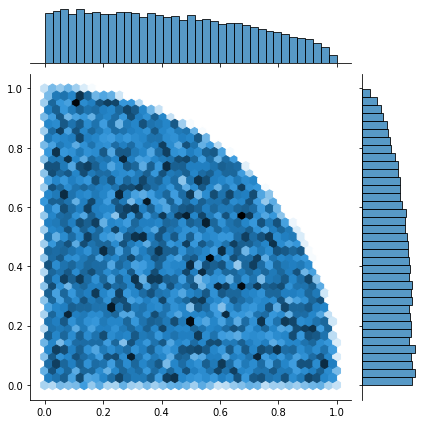

In [198]:
Q = results['posterior']['Q'][:].values.flatten()
chi = results['posterior']['chi'][:].values.flatten()

import seaborn as sns
g = sns.jointplot(x=Q, y=chi,kind='hex')


In [165]:
at.stack([[(chi**0) * (Q**0),(chi**0) * (Q**1),(chi**0) * (Q**2),(chi**0) * (Q**3)],
                                     [(chi**1) * (Q**0),(chi**1) * (Q**1),(chi**1) * (Q**2),(chi**1) * (Q**3)],
                                     [(chi**2) * (Q**0),(chi**2) * (Q**1),(chi**2) * (Q**2),(chi**2) * (Q**3)],
                                     [(chi**3) * (Q**0),(chi**3) * (Q**1),(chi**3) * (Q**2),(chi**3) * (Q**3)]]).eval()

array([[1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e-01, 1.e-02, 1.e-03, 1.e-04],
       [1.e-02, 1.e-03, 1.e-04, 1.e-05],
       [1.e-03, 1.e-04, 1.e-05, 1.e-06]])

In [167]:
chi=0.1; Q=0.1


ans = chiq_exact_factors_new(chi,Q, Y0_bij, cij)

In [163]:
%%time

f_exact = f0*(chiq_exact_factors(chi, Q_charge, **omegas))

CPU times: user 459 µs, sys: 11 µs, total: 470 µs
Wall time: 546 µs


In [161]:
%%time

ans.eval()

CPU times: user 243 µs, sys: 11 µs, total: 254 µs
Wall time: 263 µs


array([0.38716871, 0.36271016])

In [162]:
s = (at.as_tensor_variable(omegas['bij'][0])*at.as_tensor_variable(omegas['bij'][0])).sum()


In [56]:
(np.array(omegas['bij'][0])*np.array(omegas['bij'][0])).sum()

105.59658488648

In [141]:
FREF = 2985.668287014743
MREF = 68.0

M = 70.0
f0 = FREF*MREF/M

#f = f0*(chiq_exact_factors(chi, Q_charge, b_omega, c_omega, Y0_omega))
#gamma = f0*(chiq_exact_factors(chi, Q_charge, b_gamma, c_gamma, Y0_gamma))

chi = 0.7
Q_charge = 0.1

omegas = {'bij': interpolation_coeffs['b_omega'], 
          'cij': interpolation_coeffs['c_omega'], 
          'Y0': interpolation_coeffs['Y0_omega']}

gammas = {'bij': interpolation_coeffs['b_gamma'], 
          'cij': interpolation_coeffs['c_gamma'], 
          'Y0': interpolation_coeffs['Y0_gamma']}

f_exact = f0*(chiq_exact_factors(chi, Q_charge, **omegas))
gamma_exact = f0*(chiq_exact_factors(chi, Q_charge, **gammas))

#f_approx = f0*(chi_factors(chi, f_coeffs) + q*chi_factors(chi, df_coeffs))
#gamma_approx = f0*(chi_factors(chi, g_coeffs) + q*chi_factors(chi, dg_coeffs))
f_exact

array([1550.0039498 , 1516.58866255])

In [140]:
[[f"(chi**{j}) * (Q**{i})" for i in range(4)] for j in range(4)]

chi=0.7
Q=0.1
chi_Q = at.as_tensor_variable([[(chi**0) * (Q**0),(chi**0) * (Q**1),(chi**0) * (Q**2),(chi**0) * (Q**3)],
 [(chi**1) * (Q**0),(chi**1) * (Q**1),(chi**1) * (Q**2),(chi**1) * (Q**3)],
 [(chi**2) * (Q**0),(chi**2) * (Q**1),(chi**2) * (Q**2),(chi**2) * (Q**3)],
 [(chi**3) * (Q**0),(chi**3) * (Q**1),(chi**3) * (Q**2),(chi**3) * (Q**3)]])

Y0_bij = at.as_tensor_variable([omegas['Y0'][mode]*np.array(omegas['bij'][mode]) for mode in range(len(omegas['bij']))])
cij = at.as_tensor_variable(omegas['cij'])

f0*(at.tensordot(Y0_bij, chi_Q,axes=[[1,2],[0,1]])/(at.tensordot(cij, chi_Q,axes=[[1,2],[0,1]]))).eval()

array([1550.0039498 , 1516.58866255])

In [111]:
bij[0,0,1].eval()

array(0.537583)

array([1344.40394417, 1246.72952314])

In [90]:
bij.shape

TensorConstant{[2 4 4]}

In [128]:
Y0.eval()

array([0.37367168, 0.34671099])

In [96]:
chi_Q.shape

TensorConstant{(2,) of 4}

In [131]:
at.dot(Y0, bij).eval()

ERROR (aesara.graph.opt): Optimization failure due to: constant_folding
ERROR (aesara.graph.opt): node: dot(TensorConstant{[[0.373671..34671099]]}, TensorConstant{[[ 1.     ..0.838109]]})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/aesara/tensor/basic_opt.py", line 2785, in constant_folding
    required = thunk()
  File "/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/aesara/graph/op.py", line 543, in rval
    r = p(n, [x[0] for x in i], o)
  File "/Users/asadh/Documents/GitHub/ringdb_test

ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, TensorConstant{[[ 1.     ..0.838109]]}, TensorConstant{[0.3736716...34671099]}, TensorConstant{0.0})
Toposort index: 1
Inputs types: [TensorType(float64, (None,)), TensorType(float64, ()), TensorType(float64, (8, 4)), TensorType(float64, (2,)), TensorType(float64, ())]
Inputs shapes: [(8,), (), (8, 4), (2,), ()]
Inputs strides: [(8,), (), (8, 64), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', array([0.37367168, 0.34671099]), array(0.)]
Outputs clients: [[Reshape{2}(CGemv{inplace}.0, TensorConstant{[2 4]})]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [120]:
Y0*(at.tensordot(bij, chi_Q,axes=[[1,2],[0,1]])/(at.tensordot(cij, chi_Q,axes=[[1,2],[0,1]])))

Elemwise{mul,no_inplace}.0

In [29]:
%%time
f_exact = f0*(chiq_exact_factors(0.9999/(2**0.5), 0.9999/(2**0.5), **omegas))
gamma_exact = f0*(chiq_exact_factors(0.9999/(2**0.5), 0.9999/(2**0.5), **gammas))

CPU times: user 807 µs, sys: 1e+03 ns, total: 808 µs
Wall time: 818 µs


In [30]:
1/gamma_exact

array([0.02417134, 0.00584769])

In [31]:
1/f0*(chiq_exact_factors(0.1, 0.1, **gammas))

array([3.05891366e-05, 9.41693797e-05])

In [201]:
db

NameError: name 'db' is not defined